In [1]:
# Imports
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy, scipy.stats

# Question 1

In [2]:

# Build bandits
arm2pull = {}
arm2trueExpectedReward = {}
arm = 0
b = 5
for a in [2,3,4,5,6]:
    b = 8-a
    p = scipy.stats.beta(a,b)
    arm2pull[arm] = p
    arm2trueExpectedReward[arm] = a/(a+b)
    arm += 1
arms = list(arm2pull.keys())

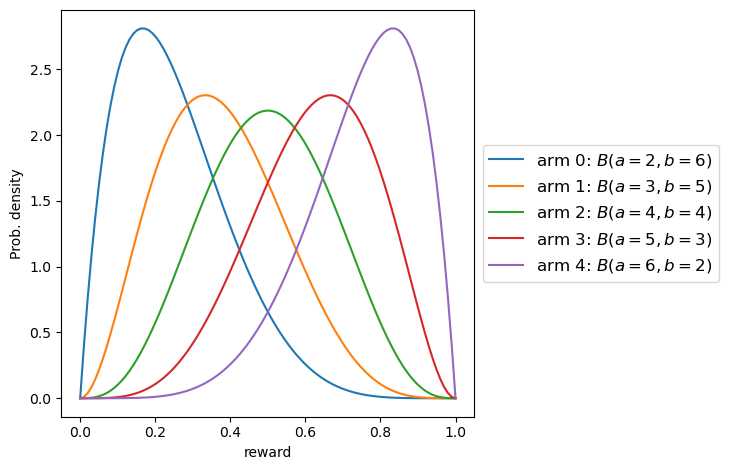

In [3]:
# Plot distributions for each arm
x = np.linspace(0,1,100)
for arm in arms:
    p = arm2pull[arm]
    a,b = p.args
    plt.plot(x,p.pdf(x), label="arm {}: $B(a = {}, b = {})$".format(arm,a,b))

# Shrink current axis by 20% to make room for legend:
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.xlabel("reward")
plt.ylabel("Prob. density")
plt.tight_layout()


In [4]:
# Define how we play an arm
def play_arm(i):
    return arm2pull[i].rvs()

# Play
for pull in range(3):
    print("Reward for pull {} =".format(pull), play_arm(3))

Reward for pull 0 = 0.8762566207697211
Reward for pull 1 = 0.24265691230229303
Reward for pull 2 = 0.5760428287854745


In [5]:
# Identify the best arm
r_star = max(arm2trueExpectedReward.values())
arm2gap = {}
for arm in arm2pull:
    r_arm = arm2trueExpectedReward[arm]
    gap = r_star - r_arm
    arm2gap[arm] = gap
#arm2gap = {arm:r_star-arm2trueExpectedReward[arm] for arm in arm2pull}
print("r* =", r_star)


r* = 0.75


# Question 2

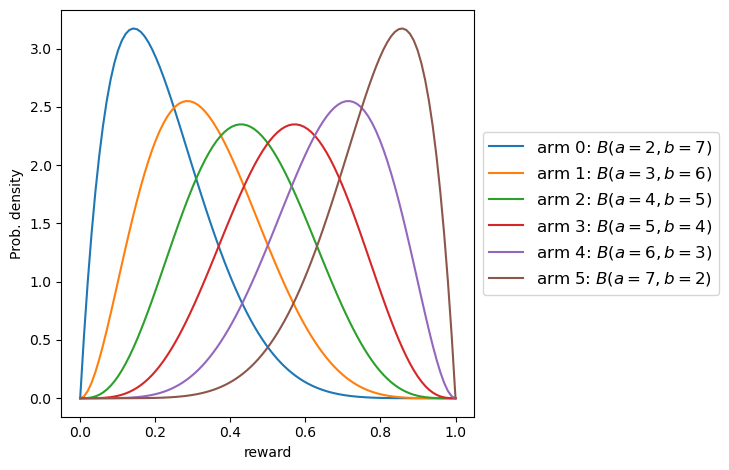

In [6]:
# 1. Random
# 2. (Naive)greedy
# 3. 𝜖-firstgreedy
# 4. 𝜖 greedy
# Build bandits

arm2pull = {}
arm2trueExpectedReward = {}
arm = 0
b = 6                           # changed from 5 to 6
for a in [2,3,4,5,6,7]:         # appended 7
    b = 9-a                     # changed to 9
    p = scipy.stats.beta(a,b)
    arm2pull[arm] = p
    arm2trueExpectedReward[arm] = a/(a+b)
    arm += 1
arms = list(arm2pull.keys())

# Plot distributions for each arm
x = np.linspace(0,1,100)
for arm in arms:
    p = arm2pull[arm]
    a,b = p.args
    plt.plot(x,p.pdf(x), label="arm {}: $B(a = {}, b = {})$".format(arm,a,b))

# Shrink current axis by 20% to make room for legend:
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.xlabel("reward")
plt.ylabel("Prob. density")
plt.tight_layout()

# Define function to calculate regret
def regret_func(time, reward):
    regret = time*max(arm2trueExpectedReward.values()) - reward
    return regret





# Random

In [7]:



def random_gamble(timesteps):
    best_arm_pulls = 0
    rewards_list = []
    for t in range(timesteps):

        # randomly choose one of the arms 
        chosen_arm = random.randint(0, 5)
        rewards_list.append(play_arm(chosen_arm))

        # if the arm is 5, count it
        if chosen_arm == 5:                                                        
            best_arm_pulls += 1

    regret = regret_func(timesteps, sum(rewards_list))
    optimal_arm_frac = best_arm_pulls / timesteps
    return regret, optimal_arm_frac





# Naive Greedy

In [8]:
def naive_greedy_gamble(timesteps):
    each_arm_rewards_estimate = [0.5] * 6
    each_arm_rewards_history = {i: [] for i in range(6)}
    totalRewards = 0.0

    for t in range(1, timesteps + 1):
        # choose the arm with the highest estimated reward
        chosen_arm = np.argmax(each_arm_rewards_estimate)

        reward = play_arm(chosen_arm)
        totalRewards += reward
        each_arm_rewards_history[chosen_arm].append(reward)

        #update estimated reward for the chosen arm
        for arm in range(6):
            if each_arm_rewards_history[arm]:
                each_arm_rewards_estimate[arm] = np.mean(each_arm_rewards_history[arm])

    regret = regret_func(timesteps, totalRewards)
    optimal_arm_frac = len(each_arm_rewards_history[5]) / timesteps if timesteps > 0 else 0

    return regret, optimal_arm_frac      




# Epsilon First Greedy

In [9]:
def epsilon_first_greedy_gamble(timesteps):
    epsilon = 0.1
    m = 10  # choose num of timesteps before we start exploitin
    each_arm_rewards_estimate = [0.5] * 6
    each_arm_rewards_history = {i: [] for i in range(6)}
    totalRewards = 0.0

    for t in range(1, timesteps + 1):
        if t <= m:
            #exploration, randomly choose arms for the first m timesteps
            chosen_arm = np.random.choice(range(6))
        else:
            # exploitation, choose the arm with the highest estimated reward
            if np.random.random() < epsilon:
                chosen_arm = np.random.choice(range(6))  # Exploration
            else:
                chosen_arm = np.argmax(each_arm_rewards_estimate)  # Exploitation again

        reward = play_arm(chosen_arm)
        totalRewards += reward
        each_arm_rewards_history[chosen_arm].append(reward)

        # update the estimated reward for the chosen arm
        for arm in range(6):
            if each_arm_rewards_history[arm]:
                each_arm_rewards_estimate[arm] = np.mean(each_arm_rewards_history[arm])

    regret = regret_func(timesteps, totalRewards)
    optimal_arm_frac = len(each_arm_rewards_history[5]) / timesteps if timesteps > 0 else 0

    return regret, optimal_arm_frac



# Epsilon Greedy

In [10]:
def epsilon_greedy_gamble(timesteps):
    epsilon = 0.1
    each_arm_rewards_estimate = [0.5] * 6
    each_arm_rewards_history = {i: [] for i in range(6)}
    totalRewards = 0.0

    for t in range(1, timesteps + 1):
        # choose between exploration and exploitation
        if np.random.random() < epsilon:
            # exploration, choose a random arm
            chosen_arm = np.random.choice(range(6))
        else:
            # exploitation, choose the arm with the highest estimated reward
            chosen_arm = np.argmax(each_arm_rewards_estimate)

        # play arm
        reward = play_arm(chosen_arm)
        totalRewards += reward

        # update the history and estimate for the chosen arm
        each_arm_rewards_history[chosen_arm].append(reward)
        each_arm_rewards_estimate[chosen_arm] = np.mean(each_arm_rewards_history[chosen_arm])

    regret = regret_func(timesteps, totalRewards)
    #calculate frac of optimal pulls
    optimal_arm_frac = len(each_arm_rewards_history[5]) / timesteps if timesteps > 0 else 0

    return regret, optimal_arm_frac




# Question 3: Plot all algorithms (6 arms) for Easy and Hard

# Easy

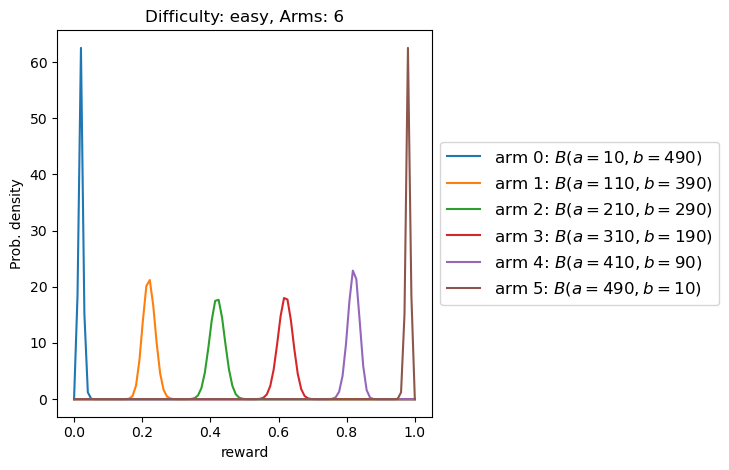

In [11]:
# Build and plot bandits 
difficulty = 'easy'
rewards_list = [10,110,210,310,410,490] 
arm2pull = {}
arm2trueExpectedReward = {}
arm = 0
# b = 5
for a in rewards_list:
    b = rewards_list[5]+rewards_list[0]-a
    p = scipy.stats.beta(a,b)
    arm2pull[arm] = p
    arm2trueExpectedReward[arm] = a/(a+b)
    arm += 1
arms = list(arm2pull.keys())

x = np.linspace(0,1,100)
for arm in arms:
    p = arm2pull[arm]
    a,b = p.args
    plt.plot(x,p.pdf(x), label="arm {}: $B(a = {}, b = {})$".format(arm, round(a, 2), round(b, 2)))

# Shrink current axis by 20% to make room for legend:
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title(f"Difficulty: {difficulty}, Arms: 6")
plt.xlabel("reward")
plt.ylabel("Prob. density")
plt.tight_layout()


# Easy: Plot all algorithms (6 arms)

In [12]:
def plot_all_algorithms(num_gambles, regretsOrFracs):
    list_times = np.array(range(1, 1000, 10))

    algorithms = [random_gamble, naive_greedy_gamble, epsilon_first_greedy_gamble, epsilon_greedy_gamble]
    algorithm_names = ['random gambles', 'naive greedy gambles', 'epsilon-first greedy gambles', 'epsilon greedy gambles']

    for i in range(len(algorithms)):
        list_regrets = []
        list_fracs = []

        for _ in range(num_gambles):
            regrets = []
            fracs = []
            for T in list_times:
                regret, frac = algorithms[i](T) 
                regrets.append(regret)
                fracs.append(frac)
            list_regrets.append(regrets)
            list_fracs.append(fracs)

        # Calculate mean regrets and fracs
        mean_regrets = np.mean(list_regrets, axis=0)
        mean_fracs = np.mean(list_fracs, axis=0)
        if regretsOrFracs == 'regrets': 
            plt.plot(list_times, mean_regrets, label=f'{num_gambles} {algorithm_names[i]}')
        elif regretsOrFracs == 'fracs':
            plt.plot(list_times, mean_fracs, label=f'{num_gambles} {algorithm_names[i]}')

    plt.legend()
    plt.title(f"6 Armed Bandit, Gambles: {num_gambles}")
    plt.xlabel("Duration of gamble $T$")
    plt.ylabel("Regret")
    plt.show()

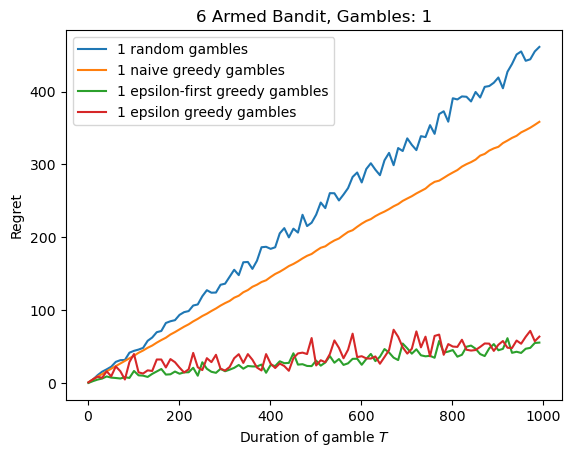

In [13]:
plot_all_algorithms(1, 'regrets')

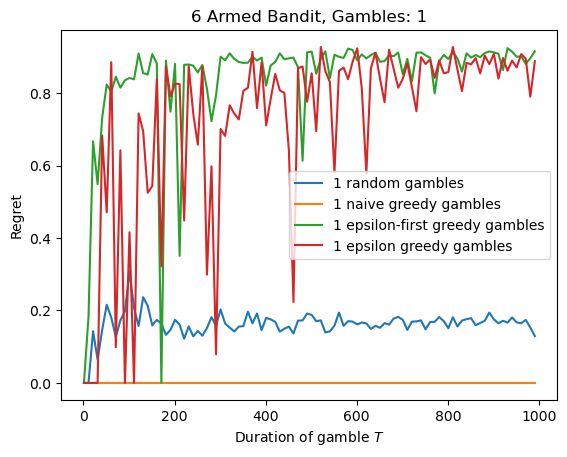

In [14]:
plot_all_algorithms(1, 'fracs')

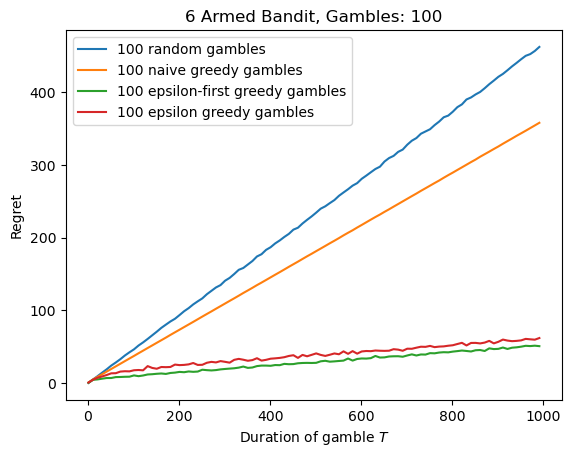

In [15]:
plot_all_algorithms(100, 'regrets')

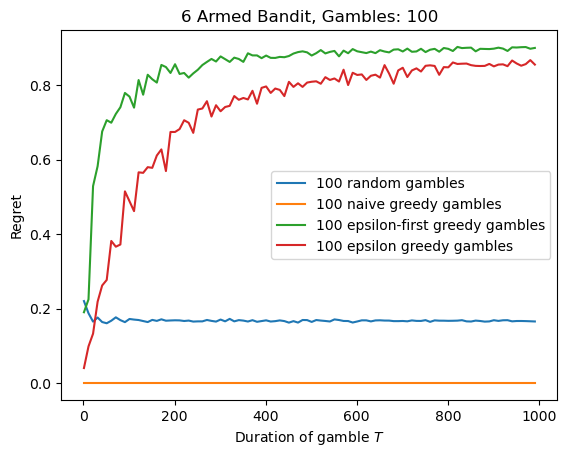

In [16]:
plot_all_algorithms(100, 'fracs')

# Hard

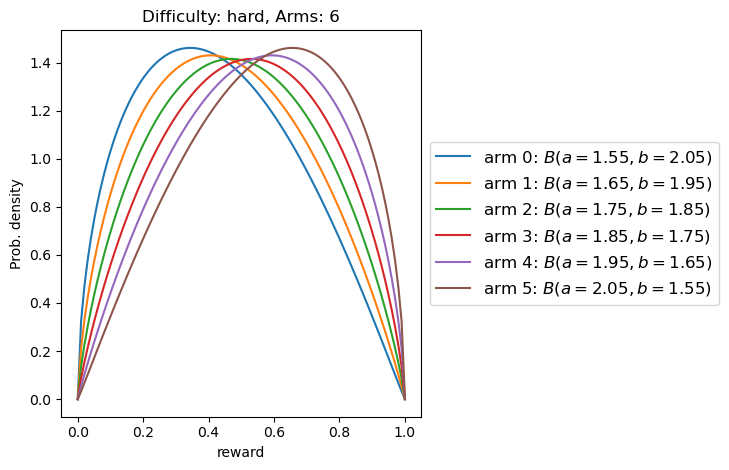

In [17]:

# Build and plot bandits 
difficulty = 'hard'
rewards_list = [1.55, 1.65, 1.75, 1.85, 1.95, 2.05]
arm2pull = {}
arm2trueExpectedReward = {}
arm = 0
# b = 5
for a in rewards_list:
    b = rewards_list[5]+rewards_list[0]-a
    p = scipy.stats.beta(a,b)
    arm2pull[arm] = p
    arm2trueExpectedReward[arm] = a/(a+b)
    arm += 1
arms = list(arm2pull.keys())

x = np.linspace(0,1,100)
for arm in arms:
    p = arm2pull[arm]
    a,b = p.args
    plt.plot(x,p.pdf(x), label="arm {}: $B(a = {}, b = {})$".format(arm, round(a, 2), round(b, 2)))

# Shrink current axis by 20% to make room for legend:
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title(f"Difficulty: {difficulty}, Arms: 6")
plt.xlabel("reward")
plt.ylabel("Prob. density")
plt.tight_layout()


# Hard: Plot all algorithms: (6 arms)

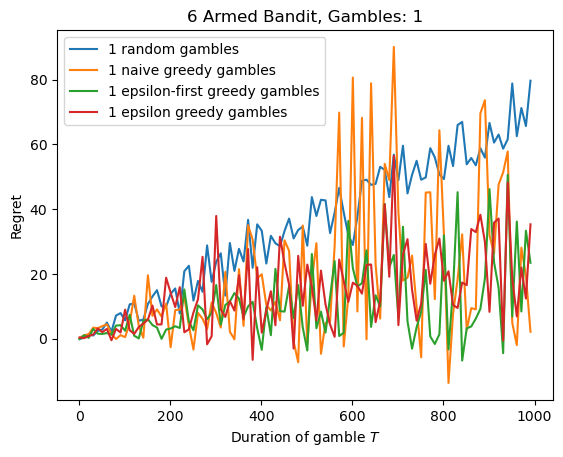

In [18]:
plot_all_algorithms(1, 'regrets')

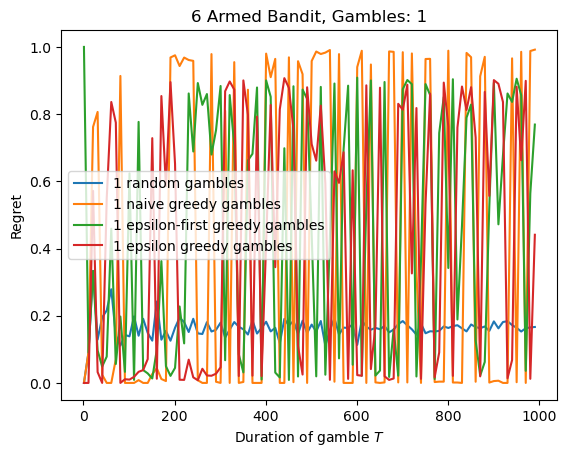

In [19]:
plot_all_algorithms(1, 'fracs')

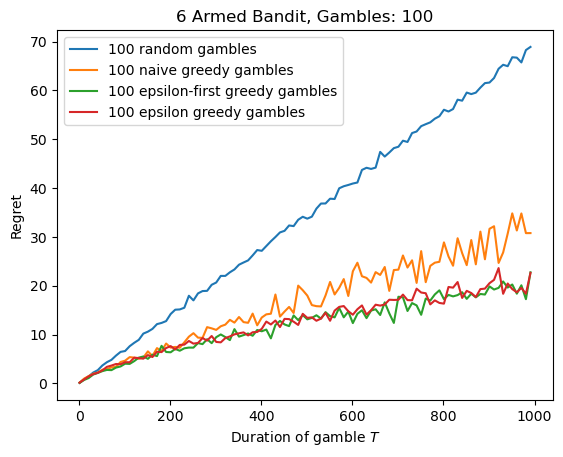

In [20]:
plot_all_algorithms(100, 'regrets')

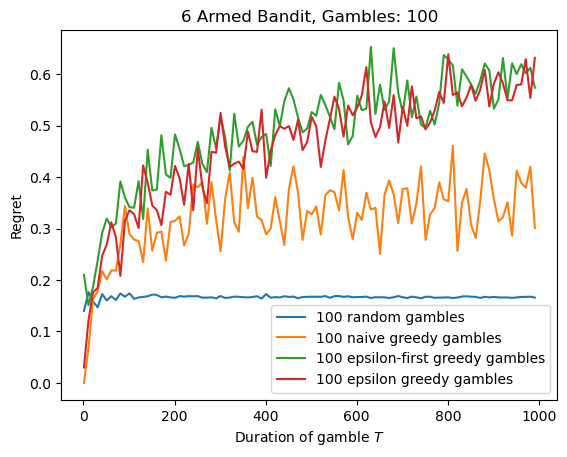

In [21]:
plot_all_algorithms(100, 'fracs')

# Question 3: UCB1 Implementation

In [22]:

def UCB1_gamble(timesteps):
    each_arm_rewards_estimate = [0.0] * 6
    each_arm_rewards_history = {i: [] for i in range(6)}
    total_rewards = 0.0

    #initial arm pulls and reward estimates
    for i in range(6):
        reward = play_arm(i)
        each_arm_rewards_history[i].append(reward)
        each_arm_rewards_estimate[i] = reward


    for t in range(6, timesteps):
        ucb_values = [estimate + math.sqrt(2 * math.log(t) / max(1, len(history))) for estimate, history in zip(each_arm_rewards_estimate, each_arm_rewards_history.values())]   #calculate j(t)
        biggest_estimate_index = np.argmax(ucb_values)

        reward = play_arm(biggest_estimate_index)
        total_rewards += reward

        # record rewards and update estimates
        each_arm_rewards_history[biggest_estimate_index].append(reward)
        each_arm_rewards_estimate[biggest_estimate_index] = np.mean(each_arm_rewards_history[biggest_estimate_index]) + math.sqrt(2 * math.log(t + 1) / len(each_arm_rewards_history[biggest_estimate_index])) # +1 aovoids log 0

    regret = regret_func(timesteps, total_rewards)
    optimal_arm_frac = len(each_arm_rewards_history[5]) / timesteps if timesteps > 0 else 0

    return regret, optimal_arm_frac

    

# Easy

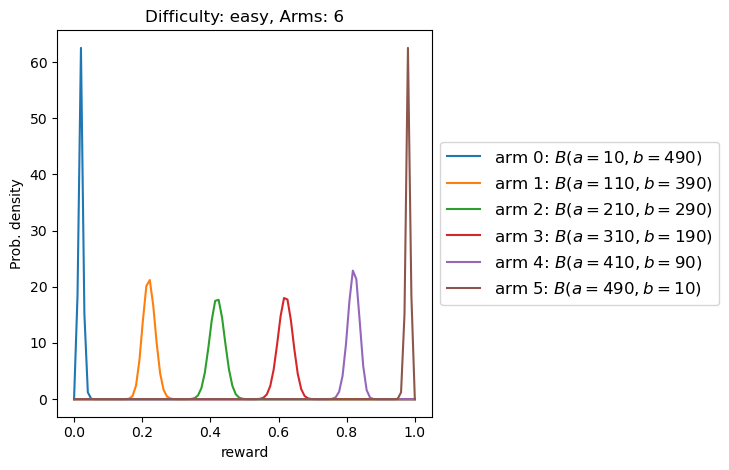

In [23]:
# Build and plot bandits 
difficulty = 'easy'
rewards_list = [10,110,210,310,410,490] 
arm2pull = {}
arm2trueExpectedReward = {}
arm = 0
# b = 5
for a in rewards_list:
    b = rewards_list[5]+rewards_list[0]-a
    p = scipy.stats.beta(a,b)
    arm2pull[arm] = p
    arm2trueExpectedReward[arm] = a/(a+b)
    arm += 1
arms = list(arm2pull.keys())

x = np.linspace(0,1,100)
for arm in arms:
    p = arm2pull[arm]
    a,b = p.args
    plt.plot(x,p.pdf(x), label="arm {}: $B(a = {}, b = {})$".format(arm, round(a, 2), round(b, 2)))

# Shrink current axis by 20% to make room for legend:
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title(f"Difficulty: {difficulty}, Arms: 6")
plt.xlabel("reward")
plt.ylabel("Prob. density")
plt.tight_layout()

# Regret Plot

In [24]:
# plotting regret, including UCB1

def plot_some_algorithms(num_gambles, regretsOrFracs):                                                                     
    list_times = np.array(range(1, 1000, 10))

    algorithms = [epsilon_first_greedy_gamble, epsilon_greedy_gamble, UCB1_gamble]
    algorithm_names = ['epsilon-first greedy gambles', 'epsilon greedy gambles', 'UCB1 gambles']

    for i in range(len(algorithms)):
        list_regrets = []
        list_fracs = []

        for _ in range(num_gambles):
            regrets = []
            fracs = []
            for T in list_times:
                regret, frac = algorithms[i](T) 
                regrets.append(regret)
                fracs.append(frac)
            list_regrets.append(regrets)
            list_fracs.append(fracs)

        # Calculate mean regrets and fracs
        mean_regrets = np.mean(list_regrets, axis=0)
        mean_fracs = np.mean(list_fracs, axis=0)
        if regretsOrFracs == 'regrets': 
            plt.plot(list_times, mean_regrets, label=f'{num_gambles} {algorithm_names[i]}')
        elif regretsOrFracs == 'fracs':
            plt.plot(list_times, mean_fracs, label=f'{num_gambles} {algorithm_names[i]}')

    plt.legend()
    plt.title("6 Armed Bandit")
    plt.xlabel("Duration of gamble $T$")
    plt.ylabel("Regret")
    plt.show()

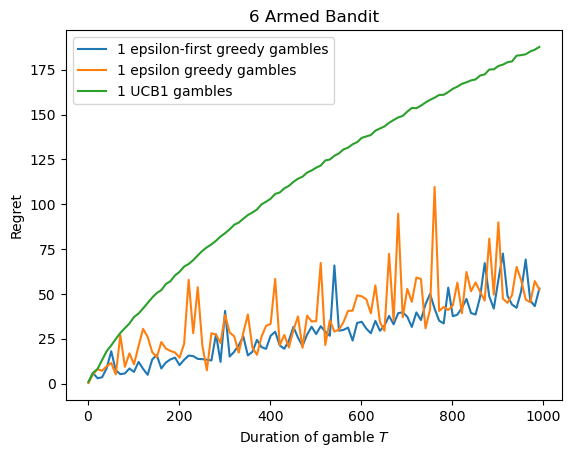

In [25]:
plot_some_algorithms(1, 'regrets')

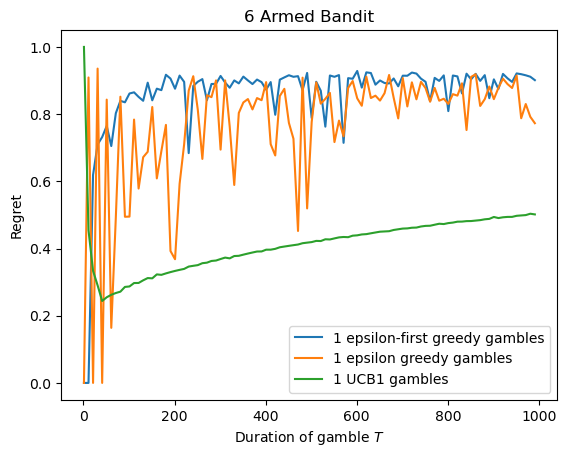

In [26]:
plot_some_algorithms(1, 'fracs')

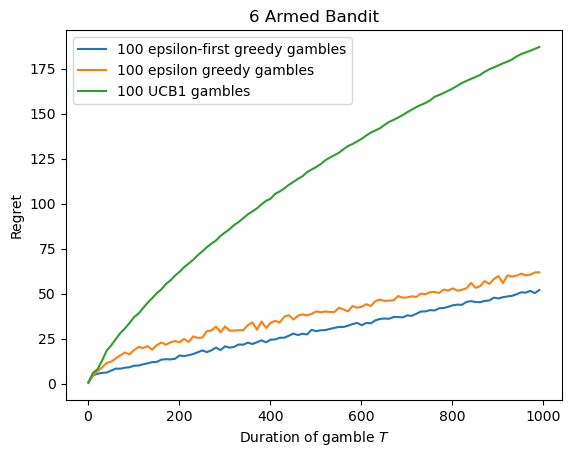

In [27]:
plot_some_algorithms(100, 'regrets')

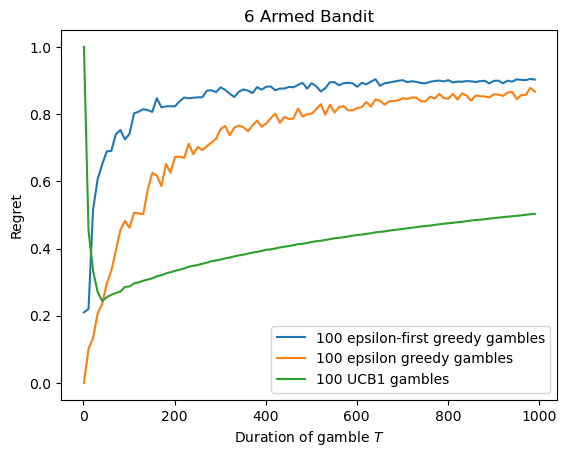

In [28]:
plot_some_algorithms(100, 'fracs')

# Hard

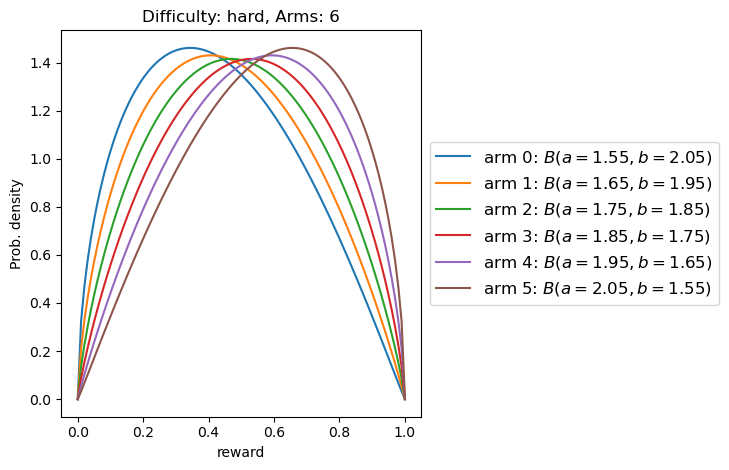

In [29]:

# Build and plot bandits 
difficulty = 'hard'
rewards_list = [1.55, 1.65, 1.75, 1.85, 1.95, 2.05]
arm2pull = {}
arm2trueExpectedReward = {}
arm = 0
# b = 5
for a in rewards_list:
    b = rewards_list[5]+rewards_list[0]-a
    p = scipy.stats.beta(a,b)
    arm2pull[arm] = p
    arm2trueExpectedReward[arm] = a/(a+b)
    arm += 1
arms = list(arm2pull.keys())

x = np.linspace(0,1,100)
for arm in arms:
    p = arm2pull[arm]
    a,b = p.args
    plt.plot(x,p.pdf(x), label="arm {}: $B(a = {}, b = {})$".format(arm, round(a, 2), round(b, 2)))

# Shrink current axis by 20% to make room for legend:
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.title(f"Difficulty: {difficulty}, Arms: 6")
plt.xlabel("reward")
plt.ylabel("Prob. density")
plt.tight_layout()

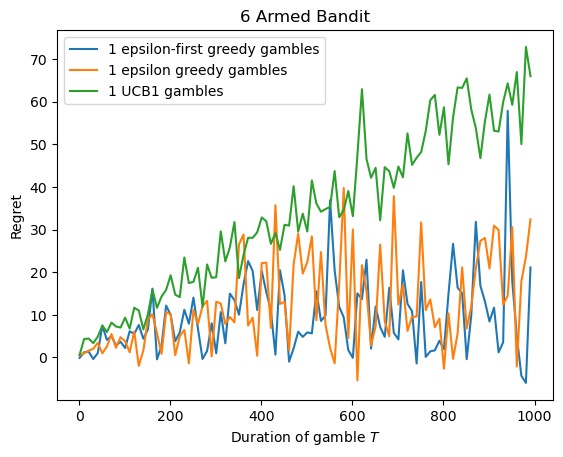

In [30]:
plot_some_algorithms(1, 'regrets')

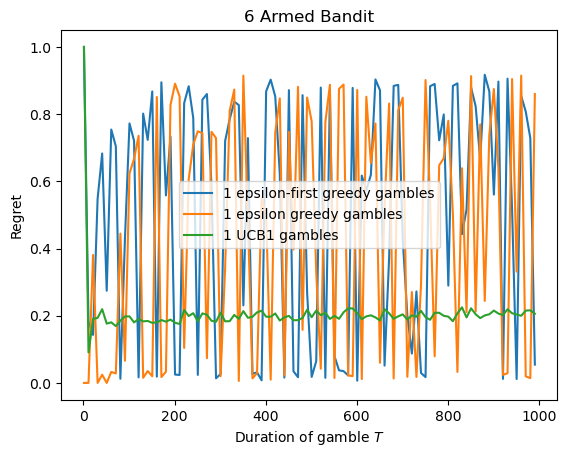

In [31]:
plot_some_algorithms(1, 'fracs')

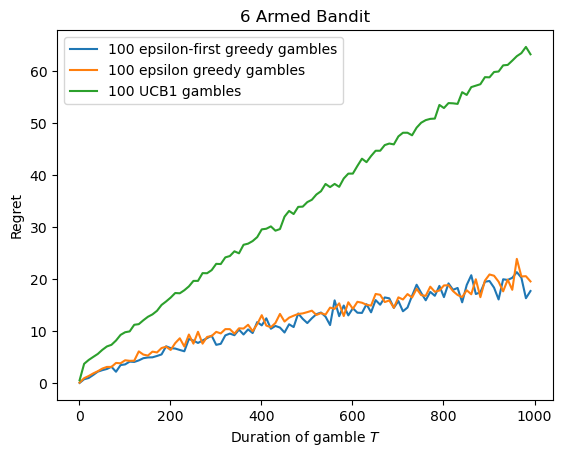

In [32]:
plot_some_algorithms(100, 'regrets')

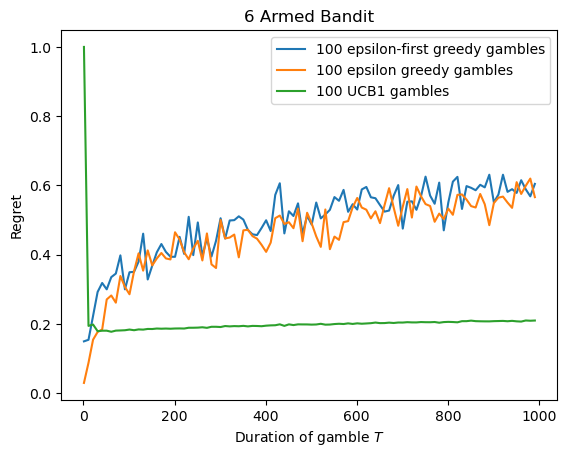

In [33]:
plot_some_algorithms(100, 'fracs')